# Test on the loss function scaling in deep and shallow circuits

In [1]:
import numpy as np
import pennylane as qml
import torch as th

In [3]:
N = 2 # number of qubits
L = 1 # number of layers

# Define a quantum device with 2 qubits
dev = qml.device("default.mixed", wires=N)
wires = np.arange(N)

In [4]:
# Define a single layer of the circuit
def layer(params):
    
    for wire,param in zip(wires,params):
        qml.RX(param, wires=wire)

    for i in range(len(wires) - 1):
        qml.CNOT(wires=[wires[i], wires[i + 1]])

    # Add a depolarizing channel to each qubit
    for wire in wires:
        qml.DepolarizingChannel(0.1, wires=wire)
   

# Define a quantum node (QNode)
@qml.qnode(dev)
def circuit(params,layers=2):

    # Add multiple layers
    for i in range(layers):  # Example: 3 layers
        layer(params[i,:]) 

    # Measure the expectation value of PauliZ on both qubits
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [5]:
# Example parameters
params = np.random.normal(size=(L,N))

# Execute the circuit
result = circuit(params,layers=L)
print("Circuit output:", result)

drawer = qml.draw(circuit, show_all_wires=True, wire_order=[0,1], decimals=1)
print(drawer(params,L))

Circuit output: (0.8488269871136118, 0.641965248976492)
0: ──RX(-0.2)─╭●──DepolarizingChannel(0.1)─┤  <Z>
1: ──RX(-0.7)─╰X──DepolarizingChannel(0.1)─┤  <Z>


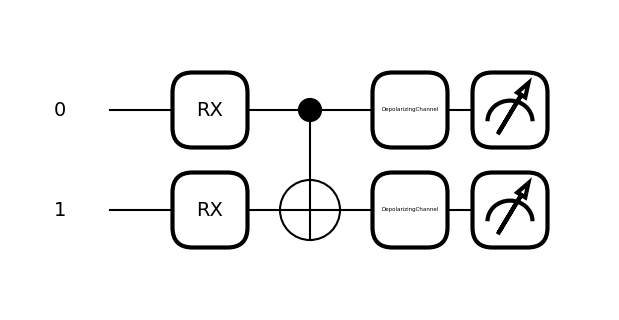

In [6]:
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(params,layers=L)

## Main test


In [ ]:
def generate_H(N):
    h = 9/N
    scale = 2**(N/2)

    Z = th.tensor([[1, 0], [0, -1]], dtype=th.complex128)

    ZZ = th.kron(Z, Z)

    H = th.zeros(2**N, 2**N, dtype=th.complex128)

    for i in range(N-1):
        H += th.kron( th.eye(2**i), th.kron(ZZ, th.eye(2**(N-i-2))) )

    return h*scale*H

def generate_dm(N,L,p):

    dev = qml.device("default.qubit", wires=N)
    @qml.qnode(dev)
    def circuit(params):
        """Build a circuit using repeated custom layers."""
        L,N = params.shape

        # Prepare GHZ state
        qml.Hadamard(wires=0)
        for i in range(1, N):
            qml.CNOT(wires=[0, i])

        for l in range(L):
            for n in range(N):
                qml.RX(params[l,n], wires=n)
            for i in range(N-1):
                qml.CNOT(wires=[i,i+1])
        return qml.state()
        
    dm_state = th.zeros(2**N, dtype=th.complex128)

    n_run = 100

    params = np.random.uniform(0, np.pi, size=(L, N))

    for _ in range(n_run):
        # Sample whether to entangle or use CNOT at each layer
        entangle_flags = np.random.rand(L) < p  # Boolean array

        last_true_idx = np.where(entangle_flags)[0][-1] if np.any(entangle_flags) else 0

        l = (L-1) - last_true_idx   # number of effective layers   
        print(entangle_flags,l)
        state = circuit(params[l:,:])

        dm_state += np.outer(state.conj(), state)

    return dm_state / n_run

def calc_variance(N,L,p):
    n_sim = 100

    H = generate_H(N)

    res = []

    for _ in range(n_sim):
        
        state = generate_dm(N,L,p)

        # Run the circuit
        res.append(th.trace(state @ H).real)
    
    return np.std(res)

In [139]:
calc_variance(2,3,1)

[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  True  True] 0
[ True  Tr

1.4282605427494147e-16

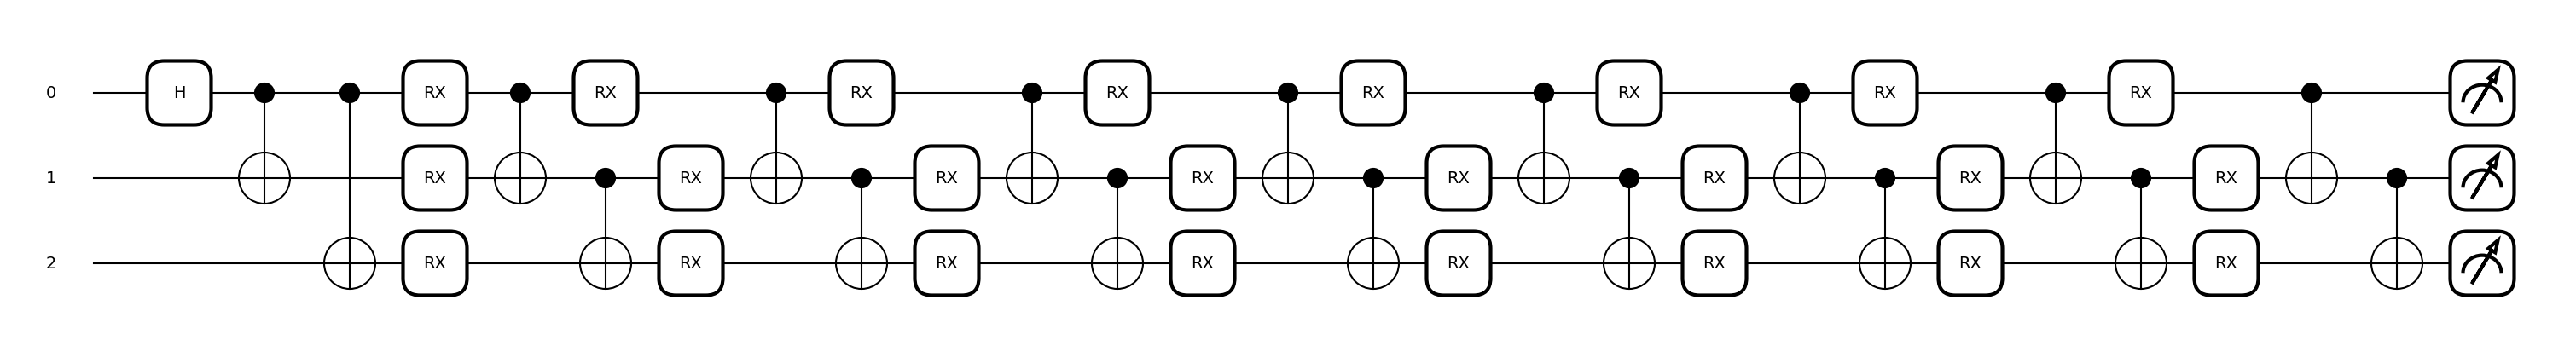

In [102]:
N = 3

dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def circuit(params):
        """Build a circuit using repeated custom layers."""
        L,N = params.shape

        # Prepare GHZ state
        qml.Hadamard(wires=0)
        for i in range(1, N):
            qml.CNOT(wires=[0, i])

        for l in range(L):
            for n in range(N):
                qml.RX(params[l,n], wires=n)
            for i in range(N-1):
                qml.CNOT(wires=[i,i+1])
        return qml.state()

params = np.random.uniform(0, np.pi, size=(8, N))
fig, ax = qml.draw_mpl(circuit,expansion_strategy="device",style="black_white")(params)